In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [2]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

with open('imglist.pt', 'rb') as f:
    images = pickle.load(f)

In [3]:
class AffonsoNet(nn.Module):

    def __init__(self,dropout = 0.5):
        super(AffonsoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=10)
        self.conv2 = nn.Conv2d(20, 25, kernel_size=10)
        self.fc1 = nn.Linear(14875,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4)
        self.mp = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv1(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv2(x)))
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return torch.log_softmax(x,1)


In [4]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            d = self.data
            l = self.labels
            self.testX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,self.data[i],axis=0)
                l += self.labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


Epoch Train Loss: 0.978386  Epoch Train Accuracy: 47.835498  Epoch Test Loss: 0.763278  Epoch Test Accuracy: 53.409091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch Train Loss: 0.773492  Epoch Train Accuracy: 49.956710  Epoch Test Loss: 0.781928  Epoch Test Accuracy: 47.727273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


Epoch Train Loss: 0.774344  Epoch Train Accuracy: 48.095238  Epoch Test Loss: 0.746305  Epoch Test Accuracy: 55.227273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


Epoch Train Loss: 0.777561  Epoch Train Accuracy: 44.935065  Epoch Test Loss: 0.756682  Epoch Test Accuracy: 52.272727


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36it/s]


Epoch Train Loss: 0.734298  Epoch Train Accuracy: 51.774892  Epoch Test Loss: 0.728919  Epoch Test Accuracy: 49.318182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


Epoch Train Loss: 0.999100  Epoch Train Accuracy: 45.174825  Epoch Test Loss: 0.827018  Epoch Test Accuracy: 41.888112


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


Epoch Train Loss: 0.751462  Epoch Train Accuracy: 52.447552  Epoch Test Loss: 0.762892  Epoch Test Accuracy: 51.188811


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.51it/s]


Epoch Train Loss: 0.752212  Epoch Train Accuracy: 50.069930  Epoch Test Loss: 0.739099  Epoch Test Accuracy: 53.566434


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56it/s]


Epoch Train Loss: 0.740450  Epoch Train Accuracy: 51.048951  Epoch Test Loss: 0.741448  Epoch Test Accuracy: 48.916084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


Epoch Train Loss: 0.751755  Epoch Train Accuracy: 48.251748  Epoch Test Loss: 0.751177  Epoch Test Accuracy: 49.265734


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.89it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10it/s]


Epoch Train Loss: 0.969611  Epoch Train Accuracy: 47.481146  Epoch Test Loss: 0.789546  Epoch Test Accuracy: 50.748663


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49it/s]


Epoch Train Loss: 0.744729  Epoch Train Accuracy: 52.184286  Epoch Test Loss: 0.758081  Epoch Test Accuracy: 49.385027


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


Epoch Train Loss: 0.737373  Epoch Train Accuracy: 52.743727  Epoch Test Loss: 0.751625  Epoch Test Accuracy: 51.203209


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


Epoch Train Loss: 0.736271  Epoch Train Accuracy: 48.805704  Epoch Test Loss: 0.726979  Epoch Test Accuracy: 52.780749


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08it/s]


Epoch Train Loss: 0.721572  Epoch Train Accuracy: 53.303167  Epoch Test Loss: 0.793683  Epoch Test Accuracy: 52.780749


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


Epoch Train Loss: 0.963351  Epoch Train Accuracy: 44.935065  Epoch Test Loss: 0.812595  Epoch Test Accuracy: 47.500000


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23it/s]


Epoch Train Loss: 0.800103  Epoch Train Accuracy: 43.506494  Epoch Test Loss: 0.784973  Epoch Test Accuracy: 52.954545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.70it/s]


Epoch Train Loss: 0.787130  Epoch Train Accuracy: 49.870130  Epoch Test Loss: 0.780478  Epoch Test Accuracy: 45.416667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch Train Loss: 0.778874  Epoch Train Accuracy: 47.402597  Epoch Test Loss: 0.707565  Epoch Test Accuracy: 60.833333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.27it/s]


Epoch Train Loss: 0.771605  Epoch Train Accuracy: 51.298701  Epoch Test Loss: 0.765030  Epoch Test Accuracy: 51.401515


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


Epoch Train Loss: 0.977447  Epoch Train Accuracy: 48.757396  Epoch Test Loss: 0.787443  Epoch Test Accuracy: 52.443182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.08it/s]


Epoch Train Loss: 0.757574  Epoch Train Accuracy: 50.739645  Epoch Test Loss: 0.749310  Epoch Test Accuracy: 47.897727


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


Epoch Train Loss: 0.746968  Epoch Train Accuracy: 49.588488  Epoch Test Loss: 0.751273  Epoch Test Accuracy: 52.301136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.22it/s]


Epoch Train Loss: 0.731541  Epoch Train Accuracy: 48.972566  Epoch Test Loss: 0.761774  Epoch Test Accuracy: 53.806818


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


Epoch Train Loss: 0.740043  Epoch Train Accuracy: 51.390533  Epoch Test Loss: 0.727460  Epoch Test Accuracy: 49.772727


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


Average Train Loss: 0.753250
Average Train Accuracy: 49.167324
Average Test Loss: 0.758665
Average Test Accuracy: 48.859129

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]


Epoch Train Loss: 0.886782  Epoch Train Accuracy: 51.388073  Epoch Test Loss: 0.779679  Epoch Test Accuracy: 52.534049


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


Epoch Train Loss: 0.741535  Epoch Train Accuracy: 48.747797  Epoch Test Loss: 0.759063  Epoch Test Accuracy: 53.018596


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.22it/s]


Epoch Train Loss: 0.747864  Epoch Train Accuracy: 48.542156  Epoch Test Loss: 0.740516  Epoch Test Accuracy: 48.978523


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


Epoch Train Loss: 0.749104  Epoch Train Accuracy: 48.946093  Epoch Test Loss: 0.752757  Epoch Test Accuracy: 43.190152


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch Train Loss: 0.742155  Epoch Train Accuracy: 50.785840  Epoch Test Loss: 0.753900  Epoch Test Accuracy: 49.214248


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch Train Loss: 0.924478  Epoch Train Accuracy: 46.802281  Epoch Test Loss: 0.880965  Epoch Test Accuracy: 47.244692


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]


Epoch Train Loss: 0.776356  Epoch Train Accuracy: 53.413962  Epoch Test Loss: 0.804328  Epoch Test Accuracy: 52.173913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


Epoch Train Loss: 0.746569  Epoch Train Accuracy: 49.161819  Epoch Test Loss: 0.741394  Epoch Test Accuracy: 47.788170


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch Train Loss: 0.731881  Epoch Train Accuracy: 48.976194  Epoch Test Loss: 0.715437  Epoch Test Accuracy: 52.173913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


Epoch Train Loss: 0.738577  Epoch Train Accuracy: 48.216473  Epoch Test Loss: 0.724018  Epoch Test Accuracy: 45.424671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.09it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


Epoch Train Loss: 1.018150  Epoch Train Accuracy: 48.566272  Epoch Test Loss: 0.771921  Epoch Test Accuracy: 47.814010


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]


Epoch Train Loss: 0.751142  Epoch Train Accuracy: 49.059053  Epoch Test Loss: 0.711799  Epoch Test Accuracy: 53.816425


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch Train Loss: 0.727141  Epoch Train Accuracy: 51.316110  Epoch Test Loss: 0.724511  Epoch Test Accuracy: 49.541063


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


Epoch Train Loss: 0.732426  Epoch Train Accuracy: 48.209361  Epoch Test Loss: 0.709963  Epoch Test Accuracy: 44.468599


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch Train Loss: 0.732192  Epoch Train Accuracy: 50.876055  Epoch Test Loss: 0.707990  Epoch Test Accuracy: 56.086957


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch Train Loss: 0.933969  Epoch Train Accuracy: 47.010870  Epoch Test Loss: 0.864984  Epoch Test Accuracy: 50.249361


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


Epoch Train Loss: 0.775441  Epoch Train Accuracy: 50.852959  Epoch Test Loss: 0.779916  Epoch Test Accuracy: 48.484655


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.22it/s]


Epoch Train Loss: 0.731667  Epoch Train Accuracy: 50.015097  Epoch Test Loss: 0.749704  Epoch Test Accuracy: 46.400256


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


Epoch Train Loss: 0.747168  Epoch Train Accuracy: 47.614734  Epoch Test Loss: 0.762595  Epoch Test Accuracy: 51.202046


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch Train Loss: 0.732635  Epoch Train Accuracy: 49.479167  Epoch Test Loss: 0.725985  Epoch Test Accuracy: 50.927110


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]


Epoch Train Loss: 0.890424  Epoch Train Accuracy: 51.782289  Epoch Test Loss: 0.893873  Epoch Test Accuracy: 52.509770


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


Epoch Train Loss: 0.735623  Epoch Train Accuracy: 51.406650  Epoch Test Loss: 0.707283  Epoch Test Accuracy: 54.085247


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch Train Loss: 0.740192  Epoch Train Accuracy: 52.213875  Epoch Test Loss: 0.719475  Epoch Test Accuracy: 50.934294


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch Train Loss: 0.728142  Epoch Train Accuracy: 51.550512  Epoch Test Loss: 0.753405  Epoch Test Accuracy: 52.381534


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


Epoch Train Loss: 0.731204  Epoch Train Accuracy: 49.128836  Epoch Test Loss: 0.715137  Epoch Test Accuracy: 50.262579


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


Average Train Loss: 0.733938
Average Train Accuracy: 49.403514
Average Test Loss: 0.736720
Average Test Accuracy: 50.422750

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch Train Loss: 1.135746  Epoch Train Accuracy: 44.044888  Epoch Test Loss: 0.778944  Epoch Test Accuracy: 49.821747


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]


Epoch Train Loss: 0.757387  Epoch Train Accuracy: 54.398816  Epoch Test Loss: 0.772942  Epoch Test Accuracy: 47.890671


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]


Epoch Train Loss: 0.749604  Epoch Train Accuracy: 50.623998  Epoch Test Loss: 0.752688  Epoch Test Accuracy: 45.929887


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.85it/s]


Epoch Train Loss: 0.753151  Epoch Train Accuracy: 51.118510  Epoch Test Loss: 0.761538  Epoch Test Accuracy: 52.748069


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.10it/s]


Epoch Train Loss: 0.741464  Epoch Train Accuracy: 50.711555  Epoch Test Loss: 0.780737  Epoch Test Accuracy: 34.893048


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.02it/s]


Epoch Train Loss: 1.145843  Epoch Train Accuracy: 45.652643  Epoch Test Loss: 0.858556  Epoch Test Accuracy: 44.509804


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.17it/s]


Epoch Train Loss: 0.785442  Epoch Train Accuracy: 52.042642  Epoch Test Loss: 0.840106  Epoch Test Accuracy: 48.797386


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]


Epoch Train Loss: 0.759412  Epoch Train Accuracy: 50.433403  Epoch Test Loss: 0.739424  Epoch Test Accuracy: 56.143791


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch Train Loss: 0.750613  Epoch Train Accuracy: 49.185862  Epoch Test Loss: 0.744258  Epoch Test Accuracy: 56.143791


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]


Epoch Train Loss: 0.751674  Epoch Train Accuracy: 49.308966  Epoch Test Loss: 0.733138  Epoch Test Accuracy: 47.568627


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.00it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.77it/s]


Epoch Train Loss: 1.149101  Epoch Train Accuracy: 41.295306  Epoch Test Loss: 0.770382  Epoch Test Accuracy: 62.497183


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch Train Loss: 0.778670  Epoch Train Accuracy: 48.354130  Epoch Test Loss: 0.741276  Epoch Test Accuracy: 57.922019


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch Train Loss: 0.760677  Epoch Train Accuracy: 47.557932  Epoch Test Loss: 0.740029  Epoch Test Accuracy: 50.845166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch Train Loss: 0.748192  Epoch Train Accuracy: 48.140226  Epoch Test Loss: 0.744641  Epoch Test Accuracy: 47.250394


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.08it/s]


Epoch Train Loss: 0.752188  Epoch Train Accuracy: 49.067142  Epoch Test Loss: 0.731134  Epoch Test Accuracy: 52.005860


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.06it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.15it/s]


Epoch Train Loss: 1.129035  Epoch Train Accuracy: 46.655354  Epoch Test Loss: 0.919873  Epoch Test Accuracy: 36.887255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.14it/s]


Epoch Train Loss: 0.762974  Epoch Train Accuracy: 50.485168  Epoch Test Loss: 0.795825  Epoch Test Accuracy: 49.959150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.14it/s]


Epoch Train Loss: 0.753000  Epoch Train Accuracy: 51.738311  Epoch Test Loss: 0.797661  Epoch Test Accuracy: 43.586601


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]


Epoch Train Loss: 0.747158  Epoch Train Accuracy: 50.054047  Epoch Test Loss: 0.774319  Epoch Test Accuracy: 52.696078


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch Train Loss: 0.747429  Epoch Train Accuracy: 51.699346  Epoch Test Loss: 0.764820  Epoch Test Accuracy: 51.470588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.03it/s]


Epoch Train Loss: 1.143743  Epoch Train Accuracy: 41.802614  Epoch Test Loss: 0.799319  Epoch Test Accuracy: 43.195612


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.03it/s]


Epoch Train Loss: 0.777925  Epoch Train Accuracy: 48.677124  Epoch Test Loss: 0.752317  Epoch Test Accuracy: 54.236695


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.10it/s]


Epoch Train Loss: 0.754714  Epoch Train Accuracy: 51.960784  Epoch Test Loss: 0.747192  Epoch Test Accuracy: 47.899160


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.00it/s]


Epoch Train Loss: 0.748679  Epoch Train Accuracy: 48.469281  Epoch Test Loss: 0.733036  Epoch Test Accuracy: 60.247432


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]


Epoch Train Loss: 0.756295  Epoch Train Accuracy: 50.669281  Epoch Test Loss: 0.757870  Epoch Test Accuracy: 50.163399


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.14it/s]


Average Train Loss: 0.747466
Average Train Accuracy: 51.252443
Average Test Loss: 0.748148
Average Test Accuracy: 49.931009

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch Train Loss: 1.244281  Epoch Train Accuracy: 42.477680  Epoch Test Loss: 0.991173  Epoch Test Accuracy: 46.285714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch Train Loss: 0.801227  Epoch Train Accuracy: 49.567232  Epoch Test Loss: 0.818458  Epoch Test Accuracy: 44.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch Train Loss: 0.796309  Epoch Train Accuracy: 50.395284  Epoch Test Loss: 0.812051  Epoch Test Accuracy: 43.428571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch Train Loss: 0.798038  Epoch Train Accuracy: 50.831459  Epoch Test Loss: 0.804516  Epoch Test Accuracy: 50.857143


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch Train Loss: 0.787301  Epoch Train Accuracy: 50.269202  Epoch Test Loss: 0.798210  Epoch Test Accuracy: 49.142857


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch Train Loss: 1.257299  Epoch Train Accuracy: 39.037610  Epoch Test Loss: 0.993651  Epoch Test Accuracy: 51.685393


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch Train Loss: 0.801077  Epoch Train Accuracy: 52.909652  Epoch Test Loss: 0.786045  Epoch Test Accuracy: 51.685393


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch Train Loss: 0.798230  Epoch Train Accuracy: 51.050054  Epoch Test Loss: 0.792999  Epoch Test Accuracy: 42.134831


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch Train Loss: 0.797017  Epoch Train Accuracy: 51.461361  Epoch Test Loss: 0.785385  Epoch Test Accuracy: 43.258427


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch Train Loss: 0.794008  Epoch Train Accuracy: 51.803827  Epoch Test Loss: 0.783358  Epoch Test Accuracy: 47.752809


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch Train Loss: 1.250002  Epoch Train Accuracy: 42.481933  Epoch Test Loss: 0.984622  Epoch Test Accuracy: 53.846154


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch Train Loss: 0.809273  Epoch Train Accuracy: 51.284471  Epoch Test Loss: 0.781938  Epoch Test Accuracy: 54.395604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch Train Loss: 0.804902  Epoch Train Accuracy: 48.157336  Epoch Test Loss: 0.772052  Epoch Test Accuracy: 60.439560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch Train Loss: 0.801717  Epoch Train Accuracy: 46.216697  Epoch Test Loss: 0.772371  Epoch Test Accuracy: 56.593407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch Train Loss: 0.798096  Epoch Train Accuracy: 52.380182  Epoch Test Loss: 0.772981  Epoch Test Accuracy: 48.901099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch Train Loss: 1.250948  Epoch Train Accuracy: 41.576726  Epoch Test Loss: 1.027545  Epoch Test Accuracy: 49.152542


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch Train Loss: 0.793764  Epoch Train Accuracy: 48.695863  Epoch Test Loss: 0.825696  Epoch Test Accuracy: 54.237288


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch Train Loss: 0.796033  Epoch Train Accuracy: 49.802823  Epoch Test Loss: 0.831326  Epoch Test Accuracy: 46.327684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch Train Loss: 0.789504  Epoch Train Accuracy: 49.754393  Epoch Test Loss: 0.829707  Epoch Test Accuracy: 48.022599


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch Train Loss: 0.790023  Epoch Train Accuracy: 51.068908  Epoch Test Loss: 0.829052  Epoch Test Accuracy: 43.502825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch Train Loss: 1.254945  Epoch Train Accuracy: 40.999572  Epoch Test Loss: 0.992696  Epoch Test Accuracy: 48.066298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch Train Loss: 0.800109  Epoch Train Accuracy: 51.384132  Epoch Test Loss: 0.802565  Epoch Test Accuracy: 53.038674


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch Train Loss: 0.799329  Epoch Train Accuracy: 50.181935  Epoch Test Loss: 0.789536  Epoch Test Accuracy: 57.458564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch Train Loss: 0.793188  Epoch Train Accuracy: 52.101170  Epoch Test Loss: 0.793316  Epoch Test Accuracy: 50.276243


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch Train Loss: 0.799802  Epoch Train Accuracy: 47.848887  Epoch Test Loss: 0.792348  Epoch Test Accuracy: 51.381215


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Average Train Loss: 0.792545
Average Train Accuracy: 49.770075
Average Test Loss: 0.794856
Average Test Accuracy: 51.075120

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 1.251854  Epoch Train Accuracy: 48.002359  Epoch Test Loss: 0.958403  Epoch Test Accuracy: 39.373023


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch Train Loss: 0.785714  Epoch Train Accuracy: 48.857438  Epoch Test Loss: 0.801916  Epoch Test Accuracy: 42.860224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch Train Loss: 0.783144  Epoch Train Accuracy: 54.054253  Epoch Test Loss: 0.787003  Epoch Test Accuracy: 44.765603


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch Train Loss: 0.786157  Epoch Train Accuracy: 50.117942  Epoch Test Loss: 0.789473  Epoch Test Accuracy: 42.306586


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch Train Loss: 0.773010  Epoch Train Accuracy: 54.179567  Epoch Test Loss: 0.798675  Epoch Test Accuracy: 41.163359


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


Epoch Train Loss: 1.260449  Epoch Train Accuracy: 46.846956  Epoch Test Loss: 0.953342  Epoch Test Accuracy: 45.997807


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 0.791068  Epoch Train Accuracy: 47.218854  Epoch Test Loss: 0.781724  Epoch Test Accuracy: 51.411732


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]


Epoch Train Loss: 0.782742  Epoch Train Accuracy: 48.932816  Epoch Test Loss: 0.794694  Epoch Test Accuracy: 41.022478


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch Train Loss: 0.784735  Epoch Train Accuracy: 54.163635  Epoch Test Loss: 0.765942  Epoch Test Accuracy: 52.439693


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch Train Loss: 0.779617  Epoch Train Accuracy: 50.521465  Epoch Test Loss: 0.777873  Epoch Test Accuracy: 44.928728


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s]


Epoch Train Loss: 1.266330  Epoch Train Accuracy: 42.745753  Epoch Test Loss: 0.956783  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch Train Loss: 0.785959  Epoch Train Accuracy: 47.925369  Epoch Test Loss: 0.765385  Epoch Test Accuracy: 57.636739


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch Train Loss: 0.788472  Epoch Train Accuracy: 49.986076  Epoch Test Loss: 0.769653  Epoch Test Accuracy: 49.406605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch Train Loss: 0.781956  Epoch Train Accuracy: 51.824004  Epoch Test Loss: 0.763809  Epoch Test Accuracy: 49.109907


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch Train Loss: 0.785546  Epoch Train Accuracy: 50.612643  Epoch Test Loss: 0.756682  Epoch Test Accuracy: 56.449948


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch Train Loss: 1.247735  Epoch Train Accuracy: 47.634712  Epoch Test Loss: 0.978569  Epoch Test Accuracy: 46.867168


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch Train Loss: 0.786049  Epoch Train Accuracy: 48.120301  Epoch Test Loss: 0.817555  Epoch Test Accuracy: 47.848789


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


Epoch Train Loss: 0.780843  Epoch Train Accuracy: 53.453947  Epoch Test Loss: 0.809549  Epoch Test Accuracy: 47.577277


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch Train Loss: 0.782032  Epoch Train Accuracy: 49.694549  Epoch Test Loss: 0.809294  Epoch Test Accuracy: 46.449457


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch Train Loss: 0.771348  Epoch Train Accuracy: 51.018170  Epoch Test Loss: 0.822536  Epoch Test Accuracy: 45.217210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch Train Loss: 1.252403  Epoch Train Accuracy: 46.518081  Epoch Test Loss: 0.938791  Epoch Test Accuracy: 52.258445


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch Train Loss: 0.797601  Epoch Train Accuracy: 48.254565  Epoch Test Loss: 0.789123  Epoch Test Accuracy: 60.199005


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]


Epoch Train Loss: 0.789660  Epoch Train Accuracy: 50.366989  Epoch Test Loss: 0.772395  Epoch Test Accuracy: 49.757790


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch Train Loss: 0.778235  Epoch Train Accuracy: 51.646975  Epoch Test Loss: 0.772723  Epoch Test Accuracy: 50.373134


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


Epoch Train Loss: 0.785606  Epoch Train Accuracy: 49.131758  Epoch Test Loss: 0.774624  Epoch Test Accuracy: 50.373134


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


Average Train Loss: 0.780052
Average Train Accuracy: 51.055036
Average Test Loss: 0.786345
Average Test Accuracy: 46.918359

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.33it/s]


Epoch Train Loss: 1.493124  Epoch Train Accuracy: 46.462993  Epoch Test Loss: 0.879529  Epoch Test Accuracy: 47.945348


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.39it/s]


Epoch Train Loss: 0.741694  Epoch Train Accuracy: 53.382433  Epoch Test Loss: 0.806531  Epoch Test Accuracy: 40.091781


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.41it/s]


Epoch Train Loss: 0.738071  Epoch Train Accuracy: 53.164212  Epoch Test Loss: 0.772248  Epoch Test Accuracy: 47.695035


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s]


Epoch Train Loss: 0.765770  Epoch Train Accuracy: 48.627023  Epoch Test Loss: 0.723228  Epoch Test Accuracy: 52.054652


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.16it/s]


Epoch Train Loss: 0.743722  Epoch Train Accuracy: 52.555010  Epoch Test Loss: 0.742046  Epoch Test Accuracy: 50.479766


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.13it/s]


Epoch Train Loss: 1.551844  Epoch Train Accuracy: 45.803783  Epoch Test Loss: 0.790914  Epoch Test Accuracy: 63.436841


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.25it/s]


Epoch Train Loss: 0.776547  Epoch Train Accuracy: 50.898345  Epoch Test Loss: 0.728066  Epoch Test Accuracy: 57.255127


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s]


Epoch Train Loss: 0.771879  Epoch Train Accuracy: 47.446809  Epoch Test Loss: 0.760959  Epoch Test Accuracy: 52.271420


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s]


Epoch Train Loss: 0.776281  Epoch Train Accuracy: 47.434988  Epoch Test Loss: 0.756157  Epoch Test Accuracy: 53.201073


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.35it/s]


Epoch Train Loss: 0.762067  Epoch Train Accuracy: 51.713948  Epoch Test Loss: 0.790153  Epoch Test Accuracy: 41.393521


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.28it/s]


Epoch Train Loss: 1.607878  Epoch Train Accuracy: 41.843972  Epoch Test Loss: 0.889748  Epoch Test Accuracy: 48.901574


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s]


Epoch Train Loss: 0.768701  Epoch Train Accuracy: 48.167849  Epoch Test Loss: 0.789646  Epoch Test Accuracy: 44.135963


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.44it/s]


Epoch Train Loss: 0.767073  Epoch Train Accuracy: 52.009456  Epoch Test Loss: 0.823042  Epoch Test Accuracy: 41.740183


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s]


Epoch Train Loss: 0.765139  Epoch Train Accuracy: 49.290780  Epoch Test Loss: 0.712652  Epoch Test Accuracy: 54.999135


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]


Epoch Train Loss: 0.820499  Epoch Train Accuracy: 46.985816  Epoch Test Loss: 0.764011  Epoch Test Accuracy: 43.469988


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.20it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s]


Epoch Train Loss: 1.588436  Epoch Train Accuracy: 46.937460  Epoch Test Loss: 0.826864  Epoch Test Accuracy: 52.925532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.35it/s]


Epoch Train Loss: 0.805869  Epoch Train Accuracy: 47.077155  Epoch Test Loss: 0.787050  Epoch Test Accuracy: 51.566194


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.45it/s]


Epoch Train Loss: 0.737646  Epoch Train Accuracy: 51.547389  Epoch Test Loss: 0.777221  Epoch Test Accuracy: 46.010638


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s]


Epoch Train Loss: 0.769002  Epoch Train Accuracy: 49.043628  Epoch Test Loss: 0.755979  Epoch Test Accuracy: 51.211584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.37it/s]


Epoch Train Loss: 0.728961  Epoch Train Accuracy: 55.738233  Epoch Test Loss: 0.770715  Epoch Test Accuracy: 54.343972


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.08it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.95it/s]


Epoch Train Loss: 1.580836  Epoch Train Accuracy: 43.177980  Epoch Test Loss: 0.876872  Epoch Test Accuracy: 47.136525


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.07it/s]


Epoch Train Loss: 0.783810  Epoch Train Accuracy: 46.133063  Epoch Test Loss: 0.809576  Epoch Test Accuracy: 46.631206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]


Epoch Train Loss: 0.745933  Epoch Train Accuracy: 53.647416  Epoch Test Loss: 0.751440  Epoch Test Accuracy: 58.723404


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s]


Epoch Train Loss: 0.749681  Epoch Train Accuracy: 50.405268  Epoch Test Loss: 0.764605  Epoch Test Accuracy: 48.386525


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]


Epoch Train Loss: 0.750494  Epoch Train Accuracy: 52.077001  Epoch Test Loss: 0.724111  Epoch Test Accuracy: 55.008865


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s]


Average Train Loss: 0.763806
Average Train Accuracy: 48.240114
Average Test Loss: 0.769676
Average Test Accuracy: 48.589232

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s]


Epoch Train Loss: 0.957250  Epoch Train Accuracy: 48.288497  Epoch Test Loss: 0.850416  Epoch Test Accuracy: 50.714286


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch Train Loss: 0.762601  Epoch Train Accuracy: 50.412801  Epoch Test Loss: 0.787035  Epoch Test Accuracy: 49.047619


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch Train Loss: 0.752040  Epoch Train Accuracy: 49.455782  Epoch Test Loss: 0.773069  Epoch Test Accuracy: 45.952381


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]


Epoch Train Loss: 0.760356  Epoch Train Accuracy: 50.219542  Epoch Test Loss: 0.776086  Epoch Test Accuracy: 41.190476


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


Epoch Train Loss: 0.762668  Epoch Train Accuracy: 47.687075  Epoch Test Loss: 0.771352  Epoch Test Accuracy: 45.714286


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 0.984464  Epoch Train Accuracy: 47.915166  Epoch Test Loss: 0.924213  Epoch Test Accuracy: 49.151990


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch Train Loss: 0.786723  Epoch Train Accuracy: 51.228491  Epoch Test Loss: 0.810181  Epoch Test Accuracy: 51.800391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch Train Loss: 0.772945  Epoch Train Accuracy: 50.564226  Epoch Test Loss: 0.768248  Epoch Test Accuracy: 44.148728


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


Epoch Train Loss: 0.765354  Epoch Train Accuracy: 47.018808  Epoch Test Loss: 0.755001  Epoch Test Accuracy: 43.405088


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


Epoch Train Loss: 0.760147  Epoch Train Accuracy: 50.684274  Epoch Test Loss: 0.755440  Epoch Test Accuracy: 45.459883


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch Train Loss: 0.981828  Epoch Train Accuracy: 45.734442  Epoch Test Loss: 0.950338  Epoch Test Accuracy: 50.389610


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


Epoch Train Loss: 0.796321  Epoch Train Accuracy: 49.599395  Epoch Test Loss: 0.750929  Epoch Test Accuracy: 49.913420


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]


Epoch Train Loss: 0.760103  Epoch Train Accuracy: 50.133535  Epoch Test Loss: 0.752583  Epoch Test Accuracy: 50.043290


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 0.764169  Epoch Train Accuracy: 49.503653  Epoch Test Loss: 0.740879  Epoch Test Accuracy: 46.493506


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch Train Loss: 0.768912  Epoch Train Accuracy: 50.864198  Epoch Test Loss: 0.742650  Epoch Test Accuracy: 52.987013


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]


Epoch Train Loss: 0.959148  Epoch Train Accuracy: 48.758108  Epoch Test Loss: 0.848043  Epoch Test Accuracy: 49.107143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch Train Loss: 0.791016  Epoch Train Accuracy: 47.369087  Epoch Test Loss: 0.799167  Epoch Test Accuracy: 48.373016


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch Train Loss: 0.765400  Epoch Train Accuracy: 50.544218  Epoch Test Loss: 0.798119  Epoch Test Accuracy: 48.551587


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch Train Loss: 0.764678  Epoch Train Accuracy: 47.128619  Epoch Test Loss: 0.793405  Epoch Test Accuracy: 39.305556


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch Train Loss: 0.758675  Epoch Train Accuracy: 52.040816  Epoch Test Loss: 0.789002  Epoch Test Accuracy: 51.011905


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch Train Loss: 0.963550  Epoch Train Accuracy: 48.100216  Epoch Test Loss: 0.744568  Epoch Test Accuracy: 54.661654


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


Epoch Train Loss: 0.787296  Epoch Train Accuracy: 48.018915  Epoch Test Loss: 0.781193  Epoch Test Accuracy: 50.783208


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch Train Loss: 0.753686  Epoch Train Accuracy: 54.250871  Epoch Test Loss: 0.737180  Epoch Test Accuracy: 51.441103


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch Train Loss: 0.760453  Epoch Train Accuracy: 51.398706  Epoch Test Loss: 0.743441  Epoch Test Accuracy: 55.363409


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s]


Epoch Train Loss: 0.755069  Epoch Train Accuracy: 50.408163  Epoch Test Loss: 0.743363  Epoch Test Accuracy: 50.419799


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Average Train Loss: 0.763974
Average Train Accuracy: 49.642175
Average Test Loss: 0.762574
Average Test Accuracy: 49.505743

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]


Epoch Train Loss: 1.344515  Epoch Train Accuracy: 47.948328  Epoch Test Loss: 1.280183  Epoch Test Accuracy: 53.649783


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


Epoch Train Loss: 0.830739  Epoch Train Accuracy: 51.531447  Epoch Test Loss: 0.845238  Epoch Test Accuracy: 42.023294


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]


Epoch Train Loss: 0.823024  Epoch Train Accuracy: 51.157353  Epoch Test Loss: 0.836711  Epoch Test Accuracy: 44.393283


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch Train Loss: 0.822503  Epoch Train Accuracy: 50.873860  Epoch Test Loss: 0.835986  Epoch Test Accuracy: 44.169827


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch Train Loss: 0.817585  Epoch Train Accuracy: 53.007365  Epoch Test Loss: 0.839479  Epoch Test Accuracy: 43.242145


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch Train Loss: 1.346191  Epoch Train Accuracy: 46.801413  Epoch Test Loss: 1.276172  Epoch Test Accuracy: 50.974532


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.08it/s]


Epoch Train Loss: 0.836438  Epoch Train Accuracy: 47.841444  Epoch Test Loss: 0.830606  Epoch Test Accuracy: 42.970374


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch Train Loss: 0.826596  Epoch Train Accuracy: 50.784929  Epoch Test Loss: 0.827463  Epoch Test Accuracy: 41.229210


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch Train Loss: 0.825829  Epoch Train Accuracy: 52.335165  Epoch Test Loss: 0.810493  Epoch Test Accuracy: 45.660083


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


Epoch Train Loss: 0.823371  Epoch Train Accuracy: 51.314757  Epoch Test Loss: 0.814565  Epoch Test Accuracy: 46.153846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch Train Loss: 1.346148  Epoch Train Accuracy: 44.282872  Epoch Test Loss: 1.273337  Epoch Test Accuracy: 59.615385


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch Train Loss: 0.839890  Epoch Train Accuracy: 50.959960  Epoch Test Loss: 0.814137  Epoch Test Accuracy: 50.160256


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]


Epoch Train Loss: 0.832087  Epoch Train Accuracy: 48.490590  Epoch Test Loss: 0.808126  Epoch Test Accuracy: 55.769231


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


Epoch Train Loss: 0.829668  Epoch Train Accuracy: 51.067323  Epoch Test Loss: 0.797524  Epoch Test Accuracy: 49.358974


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch Train Loss: 0.831764  Epoch Train Accuracy: 49.532651  Epoch Test Loss: 0.800132  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 1.342542  Epoch Train Accuracy: 46.297181  Epoch Test Loss: 1.279007  Epoch Test Accuracy: 47.938620


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.08it/s]


Epoch Train Loss: 0.825733  Epoch Train Accuracy: 49.145963  Epoch Test Loss: 0.866356  Epoch Test Accuracy: 47.530295


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch Train Loss: 0.821701  Epoch Train Accuracy: 50.603201  Epoch Test Loss: 0.860230  Epoch Test Accuracy: 45.054004


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch Train Loss: 0.814734  Epoch Train Accuracy: 51.343765  Epoch Test Loss: 0.856309  Epoch Test Accuracy: 48.142782


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


Epoch Train Loss: 0.812716  Epoch Train Accuracy: 52.741280  Epoch Test Loss: 0.859519  Epoch Test Accuracy: 51.508166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch Train Loss: 1.344965  Epoch Train Accuracy: 46.278721  Epoch Test Loss: 1.276222  Epoch Test Accuracy: 64.029720


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]


Epoch Train Loss: 0.834432  Epoch Train Accuracy: 48.364136  Epoch Test Loss: 0.819483  Epoch Test Accuracy: 58.185564


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


Epoch Train Loss: 0.830405  Epoch Train Accuracy: 48.089411  Epoch Test Loss: 0.828789  Epoch Test Accuracy: 49.650350


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch Train Loss: 0.828266  Epoch Train Accuracy: 50.924076  Epoch Test Loss: 0.805166  Epoch Test Accuracy: 50.156094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s]


Epoch Train Loss: 0.832363  Epoch Train Accuracy: 46.778222  Epoch Test Loss: 0.837260  Epoch Test Accuracy: 50.156094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]


Average Train Loss: 0.820784
Average Train Accuracy: 50.610945
Average Test Loss: 0.825369
Average Test Accuracy: 50.285160

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch Train Loss: 0.949382  Epoch Train Accuracy: 47.977061  Epoch Test Loss: 0.829208  Epoch Test Accuracy: 48.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch Train Loss: 0.762741  Epoch Train Accuracy: 49.210036  Epoch Test Loss: 0.751608  Epoch Test Accuracy: 55.400000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch Train Loss: 0.763662  Epoch Train Accuracy: 49.410753  Epoch Test Loss: 0.778895  Epoch Test Accuracy: 45.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.39it/s]


Epoch Train Loss: 0.755135  Epoch Train Accuracy: 52.551971  Epoch Test Loss: 0.766068  Epoch Test Accuracy: 47.200000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]


Epoch Train Loss: 0.768147  Epoch Train Accuracy: 51.098208  Epoch Test Loss: 0.786144  Epoch Test Accuracy: 48.200000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.53it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch Train Loss: 0.950449  Epoch Train Accuracy: 47.081481  Epoch Test Loss: 1.014077  Epoch Test Accuracy: 42.867925


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]


Epoch Train Loss: 0.803749  Epoch Train Accuracy: 51.362963  Epoch Test Loss: 0.831864  Epoch Test Accuracy: 51.871698


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.40it/s]


Epoch Train Loss: 0.768951  Epoch Train Accuracy: 47.770370  Epoch Test Loss: 0.792564  Epoch Test Accuracy: 49.328302


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch Train Loss: 0.766938  Epoch Train Accuracy: 49.911111  Epoch Test Loss: 0.761881  Epoch Test Accuracy: 47.841509


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch Train Loss: 0.759596  Epoch Train Accuracy: 51.400000  Epoch Test Loss: 0.747493  Epoch Test Accuracy: 44.754717


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch Train Loss: 0.971052  Epoch Train Accuracy: 46.151938  Epoch Test Loss: 0.838167  Epoch Test Accuracy: 56.224561


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.46it/s]


Epoch Train Loss: 0.774435  Epoch Train Accuracy: 50.406202  Epoch Test Loss: 0.750050  Epoch Test Accuracy: 53.747368


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch Train Loss: 0.749942  Epoch Train Accuracy: 52.744186  Epoch Test Loss: 0.735270  Epoch Test Accuracy: 52.470175


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch Train Loss: 0.756827  Epoch Train Accuracy: 49.097674  Epoch Test Loss: 0.735733  Epoch Test Accuracy: 48.807018


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]


Epoch Train Loss: 0.765279  Epoch Train Accuracy: 49.339535  Epoch Test Loss: 0.743212  Epoch Test Accuracy: 51.515789


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.45it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch Train Loss: 0.964813  Epoch Train Accuracy: 45.507692  Epoch Test Loss: 0.832911  Epoch Test Accuracy: 47.953846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch Train Loss: 0.793570  Epoch Train Accuracy: 50.775092  Epoch Test Loss: 0.814499  Epoch Test Accuracy: 47.715385


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch Train Loss: 0.761036  Epoch Train Accuracy: 50.175824  Epoch Test Loss: 0.818915  Epoch Test Accuracy: 47.715385


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]


Epoch Train Loss: 0.758922  Epoch Train Accuracy: 49.324542  Epoch Test Loss: 0.784790  Epoch Test Accuracy: 48.438462


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch Train Loss: 0.762684  Epoch Train Accuracy: 49.158974  Epoch Test Loss: 0.790202  Epoch Test Accuracy: 43.153846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.49it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch Train Loss: 0.950004  Epoch Train Accuracy: 48.211494  Epoch Test Loss: 0.850577  Epoch Test Accuracy: 48.814286


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]


Epoch Train Loss: 0.803973  Epoch Train Accuracy: 48.370881  Epoch Test Loss: 0.780921  Epoch Test Accuracy: 49.800000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]


Epoch Train Loss: 0.751943  Epoch Train Accuracy: 52.761686  Epoch Test Loss: 0.748770  Epoch Test Accuracy: 49.121429


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.40it/s]


Epoch Train Loss: 0.748317  Epoch Train Accuracy: 50.412261  Epoch Test Loss: 0.745287  Epoch Test Accuracy: 51.121429


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s]


Epoch Train Loss: 0.752721  Epoch Train Accuracy: 50.412261  Epoch Test Loss: 0.727060  Epoch Test Accuracy: 47.921429


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


Average Train Loss: 0.759850
Average Train Accuracy: 49.477121
Average Test Loss: 0.755685
Average Test Accuracy: 52.168980

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch Train Loss: 0.917847  Epoch Train Accuracy: 48.233887  Epoch Test Loss: 0.894088  Epoch Test Accuracy: 47.498743


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.769499  Epoch Train Accuracy: 50.837321  Epoch Test Loss: 0.785627  Epoch Test Accuracy: 43.815988


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 0.770521  Epoch Train Accuracy: 50.267380  Epoch Test Loss: 0.782130  Epoch Test Accuracy: 44.193062


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.63it/s]


Epoch Train Loss: 0.768714  Epoch Train Accuracy: 52.068674  Epoch Test Loss: 0.778672  Epoch Test Accuracy: 45.047763


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch Train Loss: 0.760169  Epoch Train Accuracy: 53.074866  Epoch Test Loss: 0.796226  Epoch Test Accuracy: 42.722474


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch Train Loss: 0.969743  Epoch Train Accuracy: 46.000764  Epoch Test Loss: 1.025192  Epoch Test Accuracy: 47.128852


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.41it/s]


Epoch Train Loss: 0.790905  Epoch Train Accuracy: 51.459129  Epoch Test Loss: 0.817060  Epoch Test Accuracy: 51.353875


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch Train Loss: 0.775446  Epoch Train Accuracy: 47.738732  Epoch Test Loss: 0.769750  Epoch Test Accuracy: 42.110177


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.70it/s]


Epoch Train Loss: 0.770358  Epoch Train Accuracy: 51.562261  Epoch Test Loss: 0.756134  Epoch Test Accuracy: 50.793651


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch Train Loss: 0.778747  Epoch Train Accuracy: 49.595111  Epoch Test Loss: 0.765021  Epoch Test Accuracy: 52.871148


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.28it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


Epoch Train Loss: 0.970099  Epoch Train Accuracy: 48.136967  Epoch Test Loss: 0.794960  Epoch Test Accuracy: 58.716965


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch Train Loss: 0.793965  Epoch Train Accuracy: 47.904088  Epoch Test Loss: 0.750934  Epoch Test Accuracy: 50.255754


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.778051  Epoch Train Accuracy: 49.771434  Epoch Test Loss: 0.762127  Epoch Test Accuracy: 50.703325


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch Train Loss: 0.775916  Epoch Train Accuracy: 47.904088  Epoch Test Loss: 0.757339  Epoch Test Accuracy: 53.687127


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch Train Loss: 0.776306  Epoch Train Accuracy: 50.120752  Epoch Test Loss: 0.750573  Epoch Test Accuracy: 53.410060


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.08it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 0.922247  Epoch Train Accuracy: 47.831254  Epoch Test Loss: 0.837132  Epoch Test Accuracy: 51.064084


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.788042  Epoch Train Accuracy: 50.965538  Epoch Test Loss: 0.835227  Epoch Test Accuracy: 47.477284


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch Train Loss: 0.762244  Epoch Train Accuracy: 54.263220  Epoch Test Loss: 0.813668  Epoch Test Accuracy: 44.057867


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.16it/s]


Epoch Train Loss: 0.774131  Epoch Train Accuracy: 48.469994  Epoch Test Loss: 0.787179  Epoch Test Accuracy: 46.484935


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch Train Loss: 0.767336  Epoch Train Accuracy: 49.509804  Epoch Test Loss: 0.811963  Epoch Test Accuracy: 51.865136


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.32it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.30it/s]


Epoch Train Loss: 0.915522  Epoch Train Accuracy: 49.097594  Epoch Test Loss: 0.831049  Epoch Test Accuracy: 49.858388


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.91it/s]


Epoch Train Loss: 0.809057  Epoch Train Accuracy: 49.298128  Epoch Test Loss: 0.762327  Epoch Test Accuracy: 59.956427


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.84it/s]


Epoch Train Loss: 0.767382  Epoch Train Accuracy: 50.701872  Epoch Test Loss: 0.753297  Epoch Test Accuracy: 49.607843


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.89it/s]


Epoch Train Loss: 0.775983  Epoch Train Accuracy: 49.164439  Epoch Test Loss: 0.764456  Epoch Test Accuracy: 53.562092


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch Train Loss: 0.777750  Epoch Train Accuracy: 48.262032  Epoch Test Loss: 0.746149  Epoch Test Accuracy: 54.030501


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.15it/s]


Average Train Loss: 0.771026
Average Train Accuracy: 49.443957
Average Test Loss: 0.776343
Average Test Accuracy: 47.038030

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36it/s]


Epoch Train Loss: 1.096778  Epoch Train Accuracy: 49.869016  Epoch Test Loss: 0.814525  Epoch Test Accuracy: 52.850877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47it/s]


Epoch Train Loss: 0.771475  Epoch Train Accuracy: 51.488450  Epoch Test Loss: 0.727928  Epoch Test Accuracy: 54.166667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49it/s]


Epoch Train Loss: 0.758247  Epoch Train Accuracy: 51.845678  Epoch Test Loss: 0.762679  Epoch Test Accuracy: 58.662281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16it/s]


Epoch Train Loss: 0.780671  Epoch Train Accuracy: 46.090339  Epoch Test Loss: 0.771071  Epoch Test Accuracy: 42.653509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch Train Loss: 0.762419  Epoch Train Accuracy: 54.191474  Epoch Test Loss: 0.742238  Epoch Test Accuracy: 59.100877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40it/s]


Epoch Train Loss: 1.145982  Epoch Train Accuracy: 48.121545  Epoch Test Loss: 0.811257  Epoch Test Accuracy: 51.127820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40it/s]


Epoch Train Loss: 0.791045  Epoch Train Accuracy: 51.382178  Epoch Test Loss: 0.781703  Epoch Test Accuracy: 49.310777


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


Epoch Train Loss: 0.755666  Epoch Train Accuracy: 48.774542  Epoch Test Loss: 0.823309  Epoch Test Accuracy: 44.486216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


Epoch Train Loss: 0.771717  Epoch Train Accuracy: 51.112272  Epoch Test Loss: 0.765639  Epoch Test Accuracy: 56.390977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46it/s]


Epoch Train Loss: 0.782586  Epoch Train Accuracy: 49.044447  Epoch Test Loss: 0.756313  Epoch Test Accuracy: 56.015038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


Epoch Train Loss: 1.094786  Epoch Train Accuracy: 48.223122  Epoch Test Loss: 0.816898  Epoch Test Accuracy: 56.339713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74it/s]


Epoch Train Loss: 0.771422  Epoch Train Accuracy: 49.632629  Epoch Test Loss: 0.760712  Epoch Test Accuracy: 45.055821


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


Epoch Train Loss: 0.769452  Epoch Train Accuracy: 48.882891  Epoch Test Loss: 0.791794  Epoch Test Accuracy: 42.862839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96it/s]


Epoch Train Loss: 0.759220  Epoch Train Accuracy: 47.413405  Epoch Test Loss: 0.783694  Epoch Test Accuracy: 47.248804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36it/s]


Epoch Train Loss: 0.776850  Epoch Train Accuracy: 47.833258  Epoch Test Loss: 0.727981  Epoch Test Accuracy: 57.057416


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.63it/s]


Epoch Train Loss: 1.164938  Epoch Train Accuracy: 43.446356  Epoch Test Loss: 0.943756  Epoch Test Accuracy: 41.885965


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


Epoch Train Loss: 0.788785  Epoch Train Accuracy: 50.763327  Epoch Test Loss: 0.737442  Epoch Test Accuracy: 50.438596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49it/s]


Epoch Train Loss: 0.771735  Epoch Train Accuracy: 52.041161  Epoch Test Loss: 0.771579  Epoch Test Accuracy: 46.491228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch Train Loss: 0.765002  Epoch Train Accuracy: 51.859818  Epoch Test Loss: 0.739130  Epoch Test Accuracy: 57.017544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


Epoch Train Loss: 0.784848  Epoch Train Accuracy: 48.979420  Epoch Test Loss: 0.827066  Epoch Test Accuracy: 41.008772


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


Epoch Train Loss: 1.139696  Epoch Train Accuracy: 50.824176  Epoch Test Loss: 0.879758  Epoch Test Accuracy: 43.903509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


Epoch Train Loss: 0.794860  Epoch Train Accuracy: 46.611722  Epoch Test Loss: 0.738542  Epoch Test Accuracy: 58.728070


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


Epoch Train Loss: 0.772933  Epoch Train Accuracy: 49.040871  Epoch Test Loss: 0.729928  Epoch Test Accuracy: 49.473684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


Epoch Train Loss: 0.751639  Epoch Train Accuracy: 53.928089  Epoch Test Loss: 0.831221  Epoch Test Accuracy: 44.780702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80it/s]


Epoch Train Loss: 0.770916  Epoch Train Accuracy: 47.966069  Epoch Test Loss: 0.748721  Epoch Test Accuracy: 56.842105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52it/s]


Average Train Loss: 0.767011
Average Train Accuracy: 49.131650
Average Test Loss: 0.763960
Average Test Accuracy: 50.297505

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.96it/s]


Epoch Train Loss: 1.021361  Epoch Train Accuracy: 46.969697  Epoch Test Loss: 0.811085  Epoch Test Accuracy: 42.760151


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch Train Loss: 0.781834  Epoch Train Accuracy: 47.971956  Epoch Test Loss: 0.786908  Epoch Test Accuracy: 45.619533


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


Epoch Train Loss: 0.777570  Epoch Train Accuracy: 52.037455  Epoch Test Loss: 0.796026  Epoch Test Accuracy: 41.728685


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch Train Loss: 0.781461  Epoch Train Accuracy: 51.134011  Epoch Test Loss: 0.792667  Epoch Test Accuracy: 51.286069


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.41it/s]


Epoch Train Loss: 0.776740  Epoch Train Accuracy: 52.432712  Epoch Test Loss: 0.809195  Epoch Test Accuracy: 43.047395


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.91it/s]


Epoch Train Loss: 1.025328  Epoch Train Accuracy: 45.570487  Epoch Test Loss: 0.873710  Epoch Test Accuracy: 47.016908


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.96it/s]


Epoch Train Loss: 0.809578  Epoch Train Accuracy: 46.951252  Epoch Test Loss: 0.791348  Epoch Test Accuracy: 51.231884


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch Train Loss: 0.780308  Epoch Train Accuracy: 50.772069  Epoch Test Loss: 0.775562  Epoch Test Accuracy: 42.850242


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.46it/s]


Epoch Train Loss: 0.786352  Epoch Train Accuracy: 51.731225  Epoch Test Loss: 0.772496  Epoch Test Accuracy: 54.299517


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.783912  Epoch Train Accuracy: 51.335968  Epoch Test Loss: 0.769377  Epoch Test Accuracy: 42.101449


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.25it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 1.029049  Epoch Train Accuracy: 49.520045  Epoch Test Loss: 1.005198  Epoch Test Accuracy: 50.823452


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.16it/s]


Epoch Train Loss: 0.788147  Epoch Train Accuracy: 51.966874  Epoch Test Loss: 0.764811  Epoch Test Accuracy: 48.144488


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.01it/s]


Epoch Train Loss: 0.787553  Epoch Train Accuracy: 47.242612  Epoch Test Loss: 0.768141  Epoch Test Accuracy: 51.789635


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.37it/s]


Epoch Train Loss: 0.787877  Epoch Train Accuracy: 47.637869  Epoch Test Loss: 0.753175  Epoch Test Accuracy: 51.174791


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch Train Loss: 0.783374  Epoch Train Accuracy: 48.127235  Epoch Test Loss: 0.758989  Epoch Test Accuracy: 54.896794


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.90it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch Train Loss: 1.007387  Epoch Train Accuracy: 50.435796  Epoch Test Loss: 0.800444  Epoch Test Accuracy: 52.508361


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.42it/s]


Epoch Train Loss: 0.794457  Epoch Train Accuracy: 47.410560  Epoch Test Loss: 0.834094  Epoch Test Accuracy: 45.336306


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.93it/s]


Epoch Train Loss: 0.776654  Epoch Train Accuracy: 49.472991  Epoch Test Loss: 0.812332  Epoch Test Accuracy: 44.332962


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch Train Loss: 0.789761  Epoch Train Accuracy: 46.837945  Epoch Test Loss: 0.809198  Epoch Test Accuracy: 49.163880


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch Train Loss: 0.775596  Epoch Train Accuracy: 50.831053  Epoch Test Loss: 0.815502  Epoch Test Accuracy: 53.363062


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch Train Loss: 1.022117  Epoch Train Accuracy: 49.209486  Epoch Test Loss: 0.776038  Epoch Test Accuracy: 49.702281


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 0.805654  Epoch Train Accuracy: 47.215235  Epoch Test Loss: 0.790764  Epoch Test Accuracy: 50.387597


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch Train Loss: 0.786855  Epoch Train Accuracy: 49.437058  Epoch Test Loss: 0.776071  Epoch Test Accuracy: 54.825301


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch Train Loss: 0.781633  Epoch Train Accuracy: 48.155468  Epoch Test Loss: 0.767538  Epoch Test Accuracy: 50.095495


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch Train Loss: 0.788099  Epoch Train Accuracy: 45.819859  Epoch Test Loss: 0.764317  Epoch Test Accuracy: 49.994383


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.14it/s]


Average Train Loss: 0.780521
Average Train Accuracy: 49.917070
Average Test Loss: 0.783799
Average Test Accuracy: 48.548418

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch Train Loss: 1.436456  Epoch Train Accuracy: 47.199862  Epoch Test Loss: 0.842095  Epoch Test Accuracy: 38.230994


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 0.763709  Epoch Train Accuracy: 51.761266  Epoch Test Loss: 0.722075  Epoch Test Accuracy: 60.599415


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]


Epoch Train Loss: 0.768000  Epoch Train Accuracy: 52.803578  Epoch Test Loss: 0.839169  Epoch Test Accuracy: 50.438596


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


Epoch Train Loss: 0.753953  Epoch Train Accuracy: 53.402133  Epoch Test Loss: 0.778361  Epoch Test Accuracy: 38.523392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s]


Epoch Train Loss: 0.770136  Epoch Train Accuracy: 45.304438  Epoch Test Loss: 0.697863  Epoch Test Accuracy: 59.429825


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch Train Loss: 1.555127  Epoch Train Accuracy: 44.067157  Epoch Test Loss: 0.944303  Epoch Test Accuracy: 40.601504


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch Train Loss: 0.782811  Epoch Train Accuracy: 48.330504  Epoch Test Loss: 0.725206  Epoch Test Accuracy: 68.588137


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch Train Loss: 0.771698  Epoch Train Accuracy: 51.843048  Epoch Test Loss: 0.832784  Epoch Test Accuracy: 37.092732


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch Train Loss: 0.761504  Epoch Train Accuracy: 51.492171  Epoch Test Loss: 0.702054  Epoch Test Accuracy: 63.199666


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch Train Loss: 0.759532  Epoch Train Accuracy: 50.205622  Epoch Test Loss: 0.726859  Epoch Test Accuracy: 51.086048


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch Train Loss: 1.501429  Epoch Train Accuracy: 40.545809  Epoch Test Loss: 0.739193  Epoch Test Accuracy: 65.018607


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


Epoch Train Loss: 0.778274  Epoch Train Accuracy: 46.666667  Epoch Test Loss: 0.720998  Epoch Test Accuracy: 44.497608


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.75it/s]


Epoch Train Loss: 0.758654  Epoch Train Accuracy: 49.122807  Epoch Test Loss: 0.769721  Epoch Test Accuracy: 46.996279


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch Train Loss: 0.736605  Epoch Train Accuracy: 56.023392  Epoch Test Loss: 0.754954  Epoch Test Accuracy: 56.804891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch Train Loss: 0.757580  Epoch Train Accuracy: 49.122807  Epoch Test Loss: 0.724671  Epoch Test Accuracy: 54.917597


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch Train Loss: 1.399487  Epoch Train Accuracy: 50.511696  Epoch Test Loss: 0.876467  Epoch Test Accuracy: 57.894737


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch Train Loss: 0.768882  Epoch Train Accuracy: 51.600877  Epoch Test Loss: 0.863096  Epoch Test Accuracy: 35.233918


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]


Epoch Train Loss: 0.768154  Epoch Train Accuracy: 47.774123  Epoch Test Loss: 0.729513  Epoch Test Accuracy: 55.847953


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch Train Loss: 0.749902  Epoch Train Accuracy: 50.040205  Epoch Test Loss: 0.744914  Epoch Test Accuracy: 58.187135


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch Train Loss: 0.736001  Epoch Train Accuracy: 52.105263  Epoch Test Loss: 0.789350  Epoch Test Accuracy: 41.520468


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch Train Loss: 1.434902  Epoch Train Accuracy: 41.645781  Epoch Test Loss: 0.897380  Epoch Test Accuracy: 45.438596


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


Epoch Train Loss: 0.793532  Epoch Train Accuracy: 47.882206  Epoch Test Loss: 0.703614  Epoch Test Accuracy: 53.391813


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


Epoch Train Loss: 0.778387  Epoch Train Accuracy: 49.064327  Epoch Test Loss: 0.686750  Epoch Test Accuracy: 66.315789


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch Train Loss: 0.759820  Epoch Train Accuracy: 51.495405  Epoch Test Loss: 0.760041  Epoch Test Accuracy: 50.760234


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


Epoch Train Loss: 0.751060  Epoch Train Accuracy: 48.725982  Epoch Test Loss: 0.719864  Epoch Test Accuracy: 50.146199


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]


Average Train Loss: 0.751376
Average Train Accuracy: 50.945711
Average Test Loss: 0.750484
Average Test Accuracy: 54.380041

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch Train Loss: 1.011232  Epoch Train Accuracy: 43.885403  Epoch Test Loss: 0.846910  Epoch Test Accuracy: 45.142857


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch Train Loss: 0.742693  Epoch Train Accuracy: 53.933214  Epoch Test Loss: 0.808009  Epoch Test Accuracy: 49.142857


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch Train Loss: 0.728683  Epoch Train Accuracy: 52.460282  Epoch Test Loss: 0.749179  Epoch Test Accuracy: 44.571429


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch Train Loss: 0.733892  Epoch Train Accuracy: 51.663429  Epoch Test Loss: 0.732624  Epoch Test Accuracy: 51.428571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch Train Loss: 0.727291  Epoch Train Accuracy: 52.878629  Epoch Test Loss: 0.752587  Epoch Test Accuracy: 44.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch Train Loss: 1.017724  Epoch Train Accuracy: 43.852143  Epoch Test Loss: 0.893402  Epoch Test Accuracy: 46.067416


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch Train Loss: 0.787852  Epoch Train Accuracy: 46.388375  Epoch Test Loss: 0.745670  Epoch Test Accuracy: 49.438202


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch Train Loss: 0.756150  Epoch Train Accuracy: 52.862576  Epoch Test Loss: 0.747098  Epoch Test Accuracy: 48.314607


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch Train Loss: 0.733544  Epoch Train Accuracy: 51.050982  Epoch Test Loss: 0.717315  Epoch Test Accuracy: 55.056180


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch Train Loss: 0.744960  Epoch Train Accuracy: 50.808151  Epoch Test Loss: 0.735121  Epoch Test Accuracy: 49.438202


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch Train Loss: 1.025196  Epoch Train Accuracy: 43.429952  Epoch Test Loss: 0.810968  Epoch Test Accuracy: 45.054945


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch Train Loss: 0.782734  Epoch Train Accuracy: 49.082126  Epoch Test Loss: 0.743366  Epoch Test Accuracy: 48.901099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch Train Loss: 0.725413  Epoch Train Accuracy: 52.741546  Epoch Test Loss: 0.718105  Epoch Test Accuracy: 54.945055


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch Train Loss: 0.734315  Epoch Train Accuracy: 48.925121  Epoch Test Loss: 0.727356  Epoch Test Accuracy: 44.505495


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch Train Loss: 0.739812  Epoch Train Accuracy: 51.908213  Epoch Test Loss: 0.721937  Epoch Test Accuracy: 51.648352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch Train Loss: 1.016210  Epoch Train Accuracy: 42.121790  Epoch Test Loss: 0.815750  Epoch Test Accuracy: 54.237288


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch Train Loss: 0.800987  Epoch Train Accuracy: 48.182049  Epoch Test Loss: 0.791550  Epoch Test Accuracy: 53.107345


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch Train Loss: 0.729846  Epoch Train Accuracy: 52.025172  Epoch Test Loss: 0.768867  Epoch Test Accuracy: 51.977401


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch Train Loss: 0.752094  Epoch Train Accuracy: 47.228579  Epoch Test Loss: 0.734664  Epoch Test Accuracy: 55.367232


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch Train Loss: 0.733778  Epoch Train Accuracy: 51.632342  Epoch Test Loss: 0.752843  Epoch Test Accuracy: 52.542373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch Train Loss: 0.995844  Epoch Train Accuracy: 46.124648  Epoch Test Loss: 0.788264  Epoch Test Accuracy: 49.723757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch Train Loss: 0.812338  Epoch Train Accuracy: 48.232203  Epoch Test Loss: 0.849890  Epoch Test Accuracy: 49.723757


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch Train Loss: 0.730514  Epoch Train Accuracy: 51.976164  Epoch Test Loss: 0.744027  Epoch Test Accuracy: 47.513812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch Train Loss: 0.737337  Epoch Train Accuracy: 49.769072  Epoch Test Loss: 0.735808  Epoch Test Accuracy: 50.828729


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch Train Loss: 0.755269  Epoch Train Accuracy: 50.988746  Epoch Test Loss: 0.732874  Epoch Test Accuracy: 49.171271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Average Train Loss: 0.740200
Average Train Accuracy: 50.075127
Average Test Loss: 0.740856
Average Test Accuracy: 51.419627

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


Epoch Train Loss: 0.872995  Epoch Train Accuracy: 49.220246  Epoch Test Loss: 0.888717  Epoch Test Accuracy: 38.604651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch Train Loss: 0.782625  Epoch Train Accuracy: 47.378021  Epoch Test Loss: 0.776136  Epoch Test Accuracy: 46.356589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.75it/s]


Epoch Train Loss: 0.778807  Epoch Train Accuracy: 51.582307  Epoch Test Loss: 0.799191  Epoch Test Accuracy: 43.875969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


Epoch Train Loss: 0.772808  Epoch Train Accuracy: 49.256726  Epoch Test Loss: 0.809645  Epoch Test Accuracy: 44.341085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch Train Loss: 0.766206  Epoch Train Accuracy: 53.616051  Epoch Test Loss: 0.829592  Epoch Test Accuracy: 42.945736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


Epoch Train Loss: 0.945124  Epoch Train Accuracy: 47.920150  Epoch Test Loss: 0.811550  Epoch Test Accuracy: 54.806202


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s]


Epoch Train Loss: 0.780520  Epoch Train Accuracy: 53.665704  Epoch Test Loss: 0.773184  Epoch Test Accuracy: 47.984496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.32it/s]


Epoch Train Loss: 0.776008  Epoch Train Accuracy: 49.151340  Epoch Test Loss: 0.759652  Epoch Test Accuracy: 51.395349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


Epoch Train Loss: 0.783016  Epoch Train Accuracy: 49.855601  Epoch Test Loss: 0.779880  Epoch Test Accuracy: 42.945736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch Train Loss: 0.781666  Epoch Train Accuracy: 50.549729  Epoch Test Loss: 0.757017  Epoch Test Accuracy: 51.395349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch Train Loss: 0.934411  Epoch Train Accuracy: 44.661869  Epoch Test Loss: 0.838605  Epoch Test Accuracy: 48.604651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


Epoch Train Loss: 0.782621  Epoch Train Accuracy: 51.870576  Epoch Test Loss: 0.744477  Epoch Test Accuracy: 45.348837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch Train Loss: 0.767266  Epoch Train Accuracy: 52.197704  Epoch Test Loss: 0.755629  Epoch Test Accuracy: 51.069767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch Train Loss: 0.773020  Epoch Train Accuracy: 50.776185  Epoch Test Loss: 0.786889  Epoch Test Accuracy: 47.860465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]


Epoch Train Loss: 0.773981  Epoch Train Accuracy: 48.914530  Epoch Test Loss: 0.756788  Epoch Test Accuracy: 51.255814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.40it/s]


Epoch Train Loss: 0.891606  Epoch Train Accuracy: 47.864960  Epoch Test Loss: 0.821917  Epoch Test Accuracy: 55.255814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.29it/s]


Epoch Train Loss: 0.782366  Epoch Train Accuracy: 52.955833  Epoch Test Loss: 0.779035  Epoch Test Accuracy: 51.720930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]


Epoch Train Loss: 0.766021  Epoch Train Accuracy: 49.242720  Epoch Test Loss: 0.816272  Epoch Test Accuracy: 51.069767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


Epoch Train Loss: 0.767271  Epoch Train Accuracy: 51.294704  Epoch Test Loss: 0.815705  Epoch Test Accuracy: 49.209302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


Epoch Train Loss: 0.780080  Epoch Train Accuracy: 48.055501  Epoch Test Loss: 0.813723  Epoch Test Accuracy: 54.604651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch Train Loss: 0.931169  Epoch Train Accuracy: 50.216598  Epoch Test Loss: 0.855866  Epoch Test Accuracy: 45.839793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch Train Loss: 0.776946  Epoch Train Accuracy: 50.763794  Epoch Test Loss: 0.753451  Epoch Test Accuracy: 49.354005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch Train Loss: 0.772906  Epoch Train Accuracy: 53.226174  Epoch Test Loss: 0.769917  Epoch Test Accuracy: 49.354005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch Train Loss: 0.772470  Epoch Train Accuracy: 49.316005  Epoch Test Loss: 0.781380  Epoch Test Accuracy: 43.979328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch Train Loss: 0.803181  Epoch Train Accuracy: 48.221614  Epoch Test Loss: 0.761591  Epoch Test Accuracy: 52.403101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Average Train Loss: 0.779046
Average Train Accuracy: 48.815977
Average Test Loss: 0.799418
Average Test Accuracy: 49.332300

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]


Epoch Train Loss: 0.940275  Epoch Train Accuracy: 48.217858  Epoch Test Loss: 0.848135  Epoch Test Accuracy: 51.293283


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]


Epoch Train Loss: 0.767085  Epoch Train Accuracy: 53.873432  Epoch Test Loss: 0.762800  Epoch Test Accuracy: 50.938673


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.08it/s]


Epoch Train Loss: 0.774116  Epoch Train Accuracy: 50.127296  Epoch Test Loss: 0.751731  Epoch Test Accuracy: 52.002503


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch Train Loss: 0.782600  Epoch Train Accuracy: 48.136025  Epoch Test Loss: 0.785673  Epoch Test Accuracy: 46.120150


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch Train Loss: 0.750147  Epoch Train Accuracy: 47.663211  Epoch Test Loss: 0.787924  Epoch Test Accuracy: 53.775553


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.28it/s]


Epoch Train Loss: 0.947339  Epoch Train Accuracy: 46.028369  Epoch Test Loss: 1.066295  Epoch Test Accuracy: 45.313399


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]


Epoch Train Loss: 0.756947  Epoch Train Accuracy: 53.605201  Epoch Test Loss: 0.788239  Epoch Test Accuracy: 47.795668


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s]


Epoch Train Loss: 0.769597  Epoch Train Accuracy: 50.531915  Epoch Test Loss: 0.738693  Epoch Test Accuracy: 57.322216


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]


Epoch Train Loss: 0.770543  Epoch Train Accuracy: 52.080378  Epoch Test Loss: 0.751557  Epoch Test Accuracy: 55.683343


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s]


Epoch Train Loss: 0.760266  Epoch Train Accuracy: 48.392435  Epoch Test Loss: 0.744082  Epoch Test Accuracy: 55.194556


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.16it/s]


Epoch Train Loss: 0.936724  Epoch Train Accuracy: 44.858156  Epoch Test Loss: 0.756441  Epoch Test Accuracy: 52.672548


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch Train Loss: 0.754754  Epoch Train Accuracy: 54.905437  Epoch Test Loss: 0.822867  Epoch Test Accuracy: 46.661477


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.97it/s]


Epoch Train Loss: 0.807473  Epoch Train Accuracy: 47.635934  Epoch Test Loss: 0.759993  Epoch Test Accuracy: 51.850891


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.06it/s]


Epoch Train Loss: 0.757468  Epoch Train Accuracy: 48.877069  Epoch Test Loss: 0.753943  Epoch Test Accuracy: 49.368621


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]


Epoch Train Loss: 0.791591  Epoch Train Accuracy: 47.163121  Epoch Test Loss: 0.780670  Epoch Test Accuracy: 47.638817


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.85it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.26it/s]


Epoch Train Loss: 1.008333  Epoch Train Accuracy: 40.242854  Epoch Test Loss: 0.791143  Epoch Test Accuracy: 49.527187


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.10it/s]


Epoch Train Loss: 0.858368  Epoch Train Accuracy: 47.786374  Epoch Test Loss: 0.869720  Epoch Test Accuracy: 48.079196


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]


Epoch Train Loss: 0.762284  Epoch Train Accuracy: 52.589727  Epoch Test Loss: 0.761264  Epoch Test Accuracy: 49.881797


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.06it/s]


Epoch Train Loss: 0.816871  Epoch Train Accuracy: 48.452611  Epoch Test Loss: 0.822620  Epoch Test Accuracy: 48.463357


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]


Epoch Train Loss: 0.759530  Epoch Train Accuracy: 46.625833  Epoch Test Loss: 0.802690  Epoch Test Accuracy: 42.494090


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.28it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.18it/s]


Epoch Train Loss: 0.948221  Epoch Train Accuracy: 52.448497  Epoch Test Loss: 0.795890  Epoch Test Accuracy: 52.491135


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.03it/s]


Epoch Train Loss: 0.828848  Epoch Train Accuracy: 47.804796  Epoch Test Loss: 0.816562  Epoch Test Accuracy: 47.154255


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]


Epoch Train Loss: 0.783463  Epoch Train Accuracy: 45.052347  Epoch Test Loss: 0.774803  Epoch Test Accuracy: 45.363475


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch Train Loss: 0.737240  Epoch Train Accuracy: 49.105032  Epoch Test Loss: 0.771683  Epoch Test Accuracy: 45.549645


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.26it/s]


Epoch Train Loss: 0.750520  Epoch Train Accuracy: 57.058426  Epoch Test Loss: 0.763840  Epoch Test Accuracy: 50.886525


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.38it/s]


Average Train Loss: 0.767372
Average Train Accuracy: 50.427509
Average Test Loss: 0.749956
Average Test Accuracy: 49.670124

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.10it/s]


Epoch Train Loss: 1.070471  Epoch Train Accuracy: 47.963943  Epoch Test Loss: 0.766522  Epoch Test Accuracy: 55.080722


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch Train Loss: 0.773517  Epoch Train Accuracy: 50.354693  Epoch Test Loss: 0.781429  Epoch Test Accuracy: 46.755302


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch Train Loss: 0.769252  Epoch Train Accuracy: 55.804429  Epoch Test Loss: 0.781720  Epoch Test Accuracy: 48.496360


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.15it/s]


Epoch Train Loss: 0.770980  Epoch Train Accuracy: 52.288850  Epoch Test Loss: 0.772901  Epoch Test Accuracy: 42.766698


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch Train Loss: 0.774313  Epoch Train Accuracy: 48.722320  Epoch Test Loss: 0.792530  Epoch Test Accuracy: 50.047483


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.05it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.75it/s]


Epoch Train Loss: 1.075900  Epoch Train Accuracy: 46.653563  Epoch Test Loss: 0.784625  Epoch Test Accuracy: 47.093621


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.93it/s]


Epoch Train Loss: 0.802670  Epoch Train Accuracy: 47.843089  Epoch Test Loss: 0.808432  Epoch Test Accuracy: 49.974280


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.62it/s]


Epoch Train Loss: 0.782361  Epoch Train Accuracy: 49.562885  Epoch Test Loss: 0.755239  Epoch Test Accuracy: 49.176955


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.80it/s]


Epoch Train Loss: 0.773380  Epoch Train Accuracy: 49.100178  Epoch Test Loss: 0.778952  Epoch Test Accuracy: 44.624486


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.87it/s]


Epoch Train Loss: 0.775034  Epoch Train Accuracy: 49.945745  Epoch Test Loss: 0.764950  Epoch Test Accuracy: 45.036008


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.03it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.34it/s]


Epoch Train Loss: 1.078456  Epoch Train Accuracy: 45.679012  Epoch Test Loss: 0.758903  Epoch Test Accuracy: 57.078189


 33%|████████████████████████████                                                        | 3/9 [00:00<00:01,  4.33it/s]

KeyboardInterrupt: 

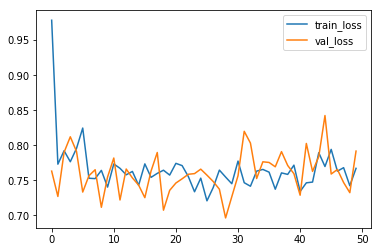

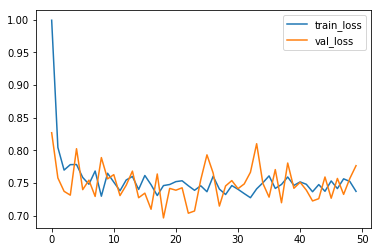

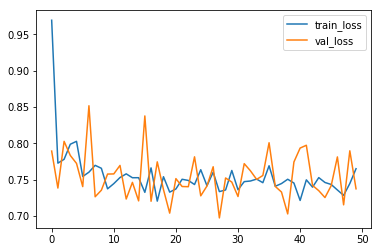

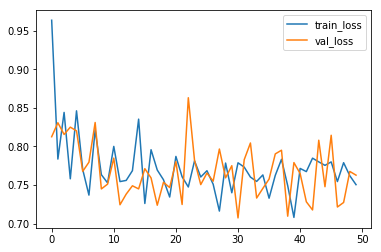

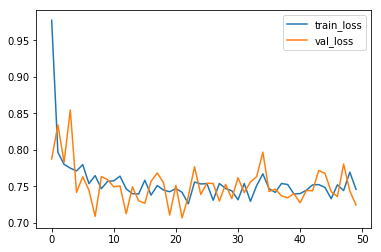

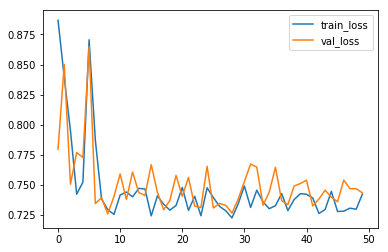

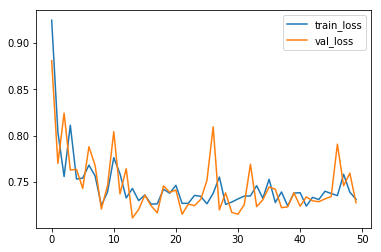

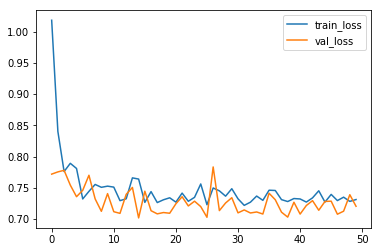

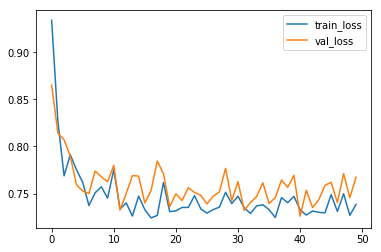

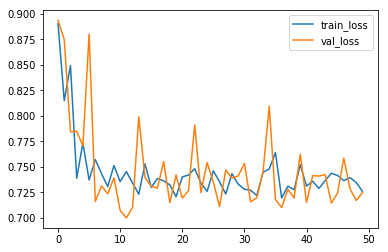

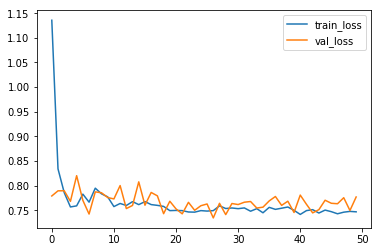

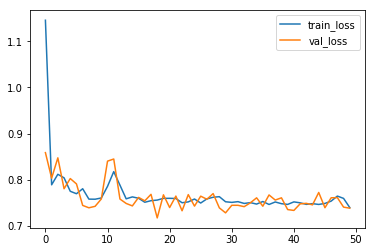

In [ ]:
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

num_attempts = 20

batch_sizes = [int(np.round(2 ** random.normalvariate(7,0.862519722))) for i in range(num_attempts)]
hidden_dims = [int(np.round(2 ** random.normalvariate(7.5,0.562519722))) for i in range(num_attempts)]
dropouts = [random.uniform(0,0.9) for i in range(num_attempts)]
weight_decays = [np.exp(random.normalvariate(0,0.5)) for i in range(num_attempts)]
stats = []

disable = False
epochs = 50
every_other = 10

for i in range(len(batch_sizes)):
    avedloss, avedacc, avevloss, avevacc = 0,0,0,0
    batch_size = batch_sizes[i]
    weight_decay = weight_decays[i]
    hidden_dim = hidden_dims[i]
    dropout = dropouts[i]
    for i in range(5):
        torch.manual_seed(4815162342)
        model = AffonsoNet(dropout=dropout).cuda()
        optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        dlosscurve = []
        dacccurve = []
        vlosscurve = []
        vacccurve = []
        print("Fold %d" % (i + 1))
        my_data.setTest(i)
        my_test.setTest(i)

        my_loader = DataLoader(my_data, batch_size=batch_size,
                                shuffle=True)
        my_test_loader = DataLoader(my_test, batch_size=batch_size,
                                shuffle=True)
        for j in range(epochs):
            dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
            vloss, vacc = test(model,criterion,my_test_loader,disable)
            dlosscurve.append(dloss)
            dacccurve.append(dacc)
            vlosscurve.append(vloss)
            vacccurve.append(vacc)
            if j % every_other == 0:
                print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
        df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
        df.plot.line()
        avedloss += dloss
        avedacc += dacc
        avevloss += vloss
        avevacc += vacc
    avedloss /= 5
    avedacc /= 0.05
    avevloss /= 5
    avevacc /= 0.05
    print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))
    stats.append([avedloss,avedacc,avevloss,avevacc])

In [1]:
for i in range(len(stats)):
    print("{:.2f} & {:.2f} & {:.2f} & {:.2f} & {} \\\\ \\hline".format(batch_sizes[i],weight_decays[i],hidden_dims[i],dropouts[i]," & ".join(["{:.2f}{}".format(stats[i][j],"\\%" if j % 2 == 1 else "") for j in range(len(stats[i]))])))

NameError: name 'stats' is not defined

In [ ]:
# hyperparameters
batch_size = 329
weight_decay = 0.39
hidden_dim = 89
dropout = 0.65
disable = False
epochs = 50
every_other = 10

# initializing training objects
torch.manual_seed(4815162342)
model = AffonsoNet(dropout=dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# initializing dataset
my_data = AutoUXDataset(data,labels,True)
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
my_loader = DataLoader(my_data, batch_size=batch_size,shuffle=True)
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
my_data.setTest(-1)
my_val.setTest(-1)

# initializing tracking variables
dlosscurve = []
dacccurve = []
vlosscurve = []
vacccurve = []

# training loop
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    vloss, vacc = test(model,criterion,my_val_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    vlosscurve.append(vloss)
    vacccurve.append(vacc)
    if j % every_other == 0:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))

print("Train Loss: {:.6f}\nTrain Accuracy: {:.6f}\nValidation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(dloss,dacc * 100,vloss,vacc * 100))
print("{:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(dloss,dacc * 100,vloss, vacc * 100))

In [ ]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

In [ ]:
false_pos = []
false_neg = []

for i in range(0,len(answers)):
#     print("{} Predicted: {} \t Actual: {}".format(images[i],int(preds[i]),int(labels[i])))
    if int(labels[i]) < int(preds[i]):
        false_pos.append(images[i])
    elif int(labels[i]) > int(preds[i]):
        false_neg.append(images[i])
print("False Positives:")
for x in false_pos:
    print(x)
print("\nFalse Negatives:")
for x in false_neg:
    print(x)

In [ ]:
with open('AffonsoNetoutprobs.pt', 'wb') as f:
    pickle.dump(answers, f)

In [ ]:
from sklearn.metrics import *
import itertools
import pickle
with open('AffonsoNetout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))